In [1]:
"""
Determinantal Point Process
===========================

This a pure Python port of the Matlab code of Alex Kulesza. 

The port was done using the fabulous SMOP package with alterations to ensure
it only used scipy/numpy packages. As such various line comments referencing
the original `*.m` file is retained in this code

If there are any errors in the port please let me know on: chpmn.siu@gmail.com
"""

import numpy as np
import random
import scipy


"""
replicate `null`
"""

import numpy as np
from numpy.linalg import svd


def rank(A, atol=1e-13, rtol=0):
    """Estimate the rank (i.e. the dimension of the nullspace) of a matrix.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length n will be treated
        as a 2-D with shape (1, n)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    r : int
        The estimated rank of the matrix.

    See also
    --------
    numpy.linalg.matrix_rank
        matrix_rank is basically the same as this function, but it does not
        provide the option of the absolute tolerance.
    """

    A = np.atleast_2d(A)
    s = svd(A, compute_uv=False)
    tol = max(atol, rtol * s[0])
    rank = int((s >= tol).sum())
    return rank


def nullspace(A, atol=1e-13, rtol=0):
    """Compute an approximate basis for the nullspace of A.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length k will be treated
        as a 2-D with shape (1, k)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    ns : ndarray
        If `A` is an array with shape (m, k), then `ns` will be an array
        with shape (k, n), where n is the estimated dimension of the
        nullspace of `A`.  The columns of `ns` are a basis for the
        nullspace; each element in numpy.dot(A, ns) will be approximately
        zero.
    """

    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return scipy.linalg.orth(ns)


def elem_sympoly(lambda_=None,k=None):
    # given a vector of lambdas and a maximum size k, determine the value of
    # the elementary symmetric polynomials:
    #   E(l+1,n+1) = sum_{J \subseteq 1..n,|J| = l} prod_{i \in J} lambda(i)
    
    N= len (lambda_)
    # elem_sympoly.m:6
    E= np.zeros((k + 1,N + 1))
    # elem_sympoly.m:7
    E[0,:]=1
     # elem_sympoly.m:8
    for l_ in range(k):
        for n_ in range(N):
            l = l_+1
            n = n_+1
            E[l,n]=E[l,n - 1] + lambda_[n - 1]*E[l-1, n-1]
    return E


    
def sample_k(lambda_=None,k=None):

    # pick k lambdas according to p(S) \propto prod(lambda \in S)
    
    # compute elementary symmetric polynomials
    E=elem_sympoly(lambda_,k)
    
    i=len(lambda_)
    remaining=k
    S = []
    while remaining > 0:

        # compute marginal of i given that we choose remaining values from 1:i
        if i == remaining:
            marg=1
        else:
            marg=np.dot(lambda_[i-1],E[remaining-1,i-1]) / E[remaining,i]
        # sample marginal
        if np.random.uniform() < marg:
            S.append(i-1) # indexing problems
            remaining=remaining - 1
        i = i - 1
    return S


def decompose_kernel(M):
    """
    Decomposes the kernel so that dpp function can sample. 
    based on: https://github.com/javiergonzalezh/dpp/blob/master/dpp/samplers/decompose_kernel.m
    
    
    this function returns:
        * M - the original kernel
        * V - eigenvectors
        * D - diagonals of eigenvalues
    """
    L = {}    
    D, V  = np.linalg.eig(M)
    L['M'] = M.copy()
    L['V'] = np.real(V.copy())
    L['D'] = np.real(D.copy())
    return L


def sample_dpp(L=None,k=None):
    """
    Sample a set from a dpp. L is the (decomposed) kernel, and k is (optionally) 
    the size of the set to return 
    """    
    if k == L['V'].shape[1]: 
        # error handling
        return list(range(k))
    if k is None:
        # choose eigenvectors randomly
        D = np.divide(L['D'], (1+L['D']))
        # check this - might just do a random.sample along axis.
        v = np.random.randint(0, L['V'].shape[1], random.choice(range(L['V'].shape[1])))
        v = np.argwhere(np.random.uniform(size=(len(D), 1) <= D))
    else:
        v = sample_k(L['D'], k)
    
    k = len(v)    
    V = L['V'][:, v]    

    # iterate
    y_index = list(range(L['V'].shape[1]))
    Y=[]
    
    for _ in range(k):
        # compute probabilities for each item
        P=np.sum(np.power(V, 2), 1)
        # sample_dpp.m:21
        # sample_dpp.m:22
        #find(rand <= cumsum(P),1)   
        
        """
        This step differs from matlab code in the following way:
            
        1.  Create vector with valid indices which can be sampled
        2.  Normalise the probabilities
        3.  Make use of `np.random.choice` to choose (guarentees that it will be a new choice for `Y`)
        """        
        P_index = [(indx, prob) for indx, prob in list(zip(range(len(P)), P)) if indx not in Y]
        P_list = [x for x, _ in P_index]
        P_norm = np.array([p for _, p in P_index])
        P_norm = P_norm/np.sum(P_norm)        
        choose_item = np.random.choice(range(len(P_list)) , 1, p=P_norm)[0]
        
        # add the index into our sampler
        Y.append(y_index[choose_item])
        if len(Y) == k:
            return Y
        
        # delete item from y_index...
        y_index.pop(choose_item)

        # update...choose a vector to elinate, lets pick randomly
        j = random.choice(range(V.shape[1]))
        Vj = V[:, j]
        V = np.delete(V, j, axis=1)
        
        # make sure we do a projection onto Vj, 
        # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4524741/
        """
        where Proj⊥Bi Bj is the the projection of Bj on the subspace perpendicular to Bi. 
        For Bi ≠ 0 and Bj = 0 the projection is ∥Proj⊥Bi Bj∥2 = 0.
        """
        # is orthogonal basis
        Vj_basis = nullspace(Vj)
        # project onto basis
        V = np.apply_along_axis(lambda x: np.dot(x, Vj_basis), 0, V)
        V = scipy.linalg.orth(V)

if __name__ == "__main__":
    # try to do a sample of stuff...
    from sklearn.metrics.pairwise import rbf_kernel
    from sklearn import datasets
    iris = datasets.load_iris()
    M = rbf_kernel(iris.data.T)
    L = decompose_kernel(M)
    indx = sample_dpp(L=L, k=3)
    print(indx)

[2, 1, 0]


In [2]:
import GPy
import matplotlib.pyplot as plt
from GPyOpt.util.general import multigrid

%matplotlib inline

In [4]:
# Genetate grid
Ngrid = 50
bounds = [(-2,2),(-2,2)]
X = multigrid(bounds, Ngrid)  

# Define kernel and kernel matrix
kernel = GPy.kern.RBF(len(bounds), variance=1, lengthscale=0.5) 
L = kernel.K(X)

# Number of points of each DPP sample
k = 50

# Putative inputs
set = [25,900, 1655,2125]


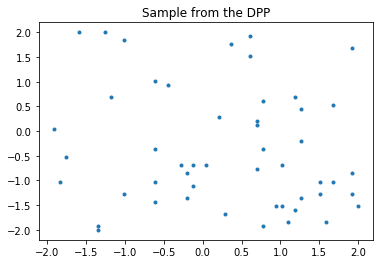

In [8]:

# Samples and plot from original and conditional with standard DPPS
sample          = sample_dpp(decompose_kernel(L),k)

plt.plot(X[sample,0],X[sample,1],'.',)
plt.title('Sample from the DPP')


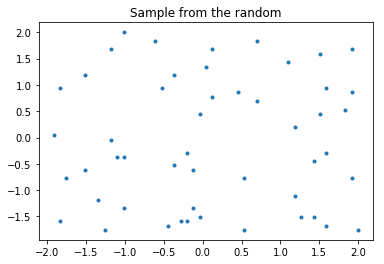

In [14]:
import random
sample1 = random.sample(range(X.shape[0]), 50)
plt.plot(X[sample1,0],X[sample1,1],'.',)
plt.title('Sample from the random')
